# 第12讲：实践：用缓存、异步与向量引擎加速你的RAG

>进阶2 中为大家介绍了几种提升 RAG 系统效率的方法，包括持久化存储、更高效的向量索引、实际项目中的工程优化以及模型推理优化等。本节作为对应的实战教程将首先为大家介绍如何使用LazyLLM实现知识库的持久化存储、随后课程将介绍LazyLLM的自定义索引组件，这里我们将手把手教您如何使用LazyLLM创建并使用自定义索引进行检索。同时，课程将介绍高性能向量数据库Milvus的基础使用方法，以及如何在LazyLLM中快速接入Milvus实现高速向量搜索。进一步，课程将介绍在 LazyLLM 中使用 vLLM 框架实现模型推理加速以及使用量化模型降低硬件要求。（关于模型蒸馏相关实战可以跳转至选修4 进行学习。）

# 环境准备及基础组件定义

如果您的电脑上安装了Python，请通过下方命令安装lazyllm及必要的依赖包。关于 LazyLLM 的环境更详细的准备可以参考第二讲中对应的内容。

```bash
pip install lazyllm
```

成功安装lazyllm后，我们进行如下组件的定义：大模型llm、向量模型embedding_model、重排模型rerank_model，这些组件在下面的实践过程当中会经常用到，该部分预先定义后，后面将不再重复定义。

对于GPU资源较紧张的开发者，推荐您全程使用线上模型，以快速上手开发，降低使用门槛。线上模型的创建如下（[代码Github链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter12/online_models.py#L31)）：

In [ ]:
from lazyllm import OnlineChatModule, OnlineEmbeddingModule

DOUBAO_API_KEY = ""
DEEPSEEK_API_KEY = ""
QWEN_API_KEY = ""

#线上大模型，此处使用DeepSeek-V3
llm = OnlineChatModule(
    source="deepseek",
    api_key=DEEPSEEK_API_KEY,
)

#向量模型，此处选用豆包向量模型
embedding_model = OnlineEmbeddingModule(
    source="doubao",
    embed_model_name="doubao-embedding-large-text-240915",
    api_key=DOUBAO_API_KEY,
)

#重排模型，线上的重排模型仅支持千问和智谱，这里使用千问重排模型
rerank_model = OnlineEmbeddingModule(
    source="qwen",
    api_key=QWEN_API_KEY,
    type="rerank"
)

对于一些期望使用远程连接方式连接向量模型，但LazyLLM内部没有支持的开发者，可以采用先前介绍的继承方式，实现两个方法后创建自定义的OnlineEmbeddingModule（[代码Github链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter12/online_models.py#L8)）：

In [ ]:
from typing import Dict, List, Union
from lazyllm.module import OnlineEmbeddingModuleBase


class CustomOnlineEmbeddingModule(OnlineEmbeddingModuleBase):
    """CustomOnlineEmbeddingModule"""

    def __init__(
            self,
            embed_url,
            embed_model_name,
            api_key,
            model_series):
        super().__init__(
            embed_url=embed_url, embed_model_name=embed_model_name, api_key=api_key, model_series=model_series
        )
    
    #实现request data封装方法
    def _encapsulated_data(self, text: str, **kwargs) -> Dict[str, str]:
        json_data = {"inputs": text, "model": self._embed_model_name}
        if len(kwargs) > 0:
            json_data.update(kwargs)

        return json_data
    
    #实现response解析方法
    def _parse_response(self, response: Union[List[List[str]], Dict]) -> Union[List[List[str]], Dict]:
        return response


# 传入正确的url和模型信息即可，以下是使用远程的bge-m3模型
embedding_model = CustomOnlineEmbeddingModule(
    embed_url="",
    embed_model_name="BAAI/bge-m3",
    api_key="",
    model_series="bge"
)

针对GPU资源相对充足，或者对模型效率或并发要求较高的场景，推荐使用lazyllm内置的TrainableModule实现模型的本地部署：

In [ ]:
from lazyllm import TrainableModule, pipeline

llm = TrainableModule('internlm2-chat-20b', stream=True)
embedding_model = TrainableModule("bge-large-zh-v1.5")
rerank_model = TrainableModule("bge-reranker-large")

pipeline(llm, embedding_model, rerank_model).start()

# 一、使用向量数据库实现知识库持久化存储

向量数据库是一种专门用于存储、管理和检索高维向量数据的数据库系统，广泛应用于搜索引擎、推荐系统、计算机视觉和自然语言处理等领域。与传统的关系型数据库不同，向量数据库能够高效存储高维向量，并采用相似度检索和优化索引技术，大幅提升大规模向量搜索的效率，是目前 AI 应用重要的数据存储和检索工具。

LazyLLM 原生支持 ChromaDB 和 Milvus 两种开源向量数据库，提供了开箱即用的向量存储和检索支持。在实际的使用过程中，用户只需要在Document定义阶段配置store_conf参数，进行简单的**存储和检索****配置**，即可利用这两种数据库将文档处理后的数据存储于本地，并在下次系统启动时直接从本地加载这些数据，避免文档的重复入库，实现知识库持久化存储。使用store_conf配置Document存储的实现方式如下：

In [ ]:
document = lazyllm.Document(dataset_path='/path/to/your/document',
           embed=lazyllm.OnlineEmbeddingModule(),
           ...,
           store_conf=store_conf)

参数**store_conf**接收字典形式的存储配置，配置时需要传入type和kwargs参数，具体字段解释如下：

- type：使用存储类型。如之前介绍，LazyLLM目前支持的存储类型有map（基于内存）、chroma（基于ChromaDB向量数据库）以及milvus（基于Milvus向量数据库）：
  - map：仅使用内存 key/value 存储暂存所有文档处理数据，系统重启后数据消失；
  - chroma：使用 ChromaDB 存储数据，ChromaDB 是一个更轻量的向量数据库，相比于 Milvus 能处理的数据量级有限，适合调试，更多 ChromoDB 相关信息可以参考 [ChromaDB 官方文档](https://www.trychroma.com/)；
  - milvus：使用 Milvus 存储数据，支持海量数据的检索和存储，支持分布式部署，更适合生产级应用，更多 Milvus 相关信息可以参考 [Milvus 官方文档](https://www.milvus-io.com/overview)；
- kwargs：具体存储所需的额外配置参数，同样以字典的形式输入。
  - 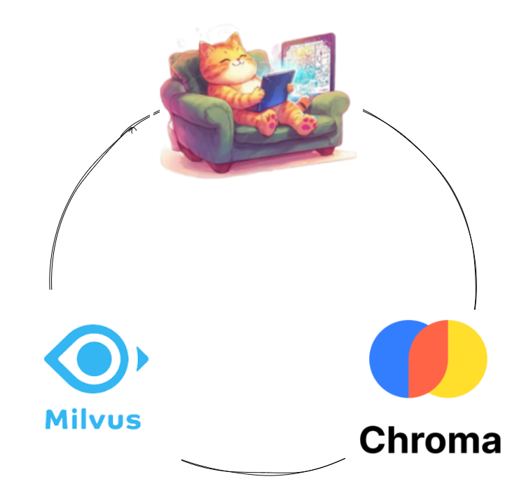

  - 当type为chroma时，所需配置参数为：
    - dir（必填）：存储数据的目录；
  - 当type为milvus时，所需配置参数为：
    - uri（必填）：存储数据地址，可以是一个**文件路径**或者**远程连接的url**；
    - index_kwargs（可选）：Milvus数据库的索引配置，可以是一个 dict 或者 list[dict]，索引配置主要包含两个字段：索引类型index_type和度量类型metric_type（即Index和Similarity，和LazyLLM的定义很像）。参数如果是一个 dict 表示所有向量模型使用相同配置；如果需要指定不同的向量模型以不同索引配置，则可以以列表的方式传入，由 embed_key 指定所使用配置即可。当前只支持 floating point embedding 和 sparse embedding 两种 embedding 类型，分别支持的参数如下，感兴趣的开发者可以前往官网查看：
      - [floating point embedding](https://milvus.io/docs/index-vector-fields.md?tab=floating)
      - [sparse embedding](https://milvus.io/docs/index-vector-fields.md?tab=sparse)


## 实践一 使用向量数据库实现持久化存储

### 系统启动性能对比

本部分在其余模块不变的情况下，分别使用内存、ChromaDB和Milvus作为数据存储。分别测试三者首次启动和二次启动耗时，以展示持久化存储对于系统二次启动效率的提升。文件目录中包含pdf、docx、txt格式的文件，按照句子分块后共计1614个节点。

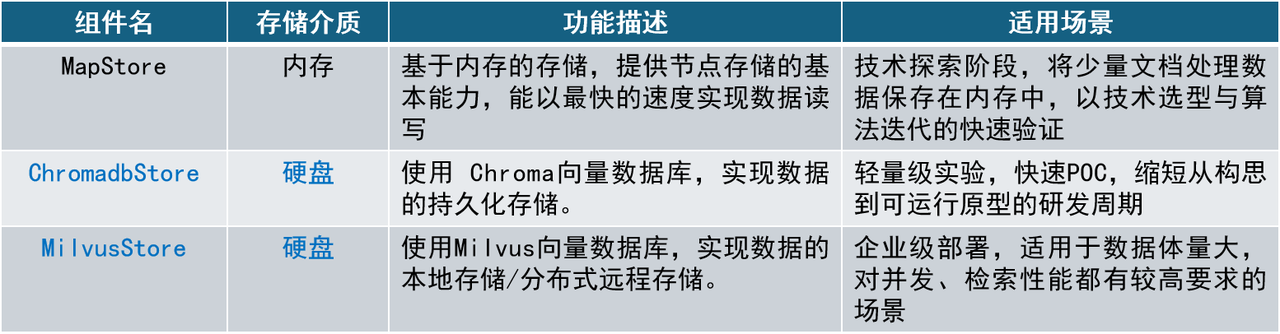

- 内存存储

由于LazyLLM默认使用内存作为存储类型，故开发者无需进行额外配置即可定义一个使用内存存储的Document：

In [ ]:
document = lazyllm.Document(
    dataset_path='/path/to/your/document',
    embed=embedding_model
)

- ChromaDB

ChromaDB以易用性、高性能和紧密集成AI应用为主要特点，适用于需要快速部署和轻量级管理的应用场景，如聊天机器人、个性化推荐、搜索引擎等。由于ChromaDB 基于 sqlite3 实现了持久化存储，因此不支持分布式部署，适用于小型本地应用。在中使用LazyLLM的ChromaDB需要在store_conf中配置如下字段：

In [ ]:
chroma_store_conf = {
  'type': 'chroma', 
  'kwargs': {
    'dir': 'dbs/test_chroma', # chromadb传入的 dir 是一个文件夹，不存在会自动创建
   }
}

document = lazyllm.Document(
    dataset_path='/path/to/your/document',
    embed=embedding_model,
    store_conf=chroma_store_conf
)

- Milvus

Milvus 作为专为高性能向量检索设计的开源向量数据库，能够高效处理万亿级别的向量索引。与 ChromaDB 相比，Milvus 除了可以提供向量存储，还提供了高速检索接口，可以基于多种索引方式实现向量的高效检索。使用 Milvus 作为存储后端，需要传入如下配置：

In [ ]:
milvus_store_conf = {
  'type': 'milvus',  # 指定存储后端类型
  'kwargs': {
    'uri': 'test.db',  # 存储后端地址，本例子使用的是本地文件 test.db，文件不存则创建新文件
    'index_kwargs': {  # 存储后端的索引配置
      'index_type': 'FLAT',  # 索引类型
      'metric_type': 'COSINE',  # 相似度计算方式
    }
  },
}

document = lazyllm.Document(
    dataset_path='/path/to/your/document',
    embed=embedding_model,
    store_conf=milvus_store_conf 
)

>请注意，目前 LazyLLM 支持 Milvus 2.4.x，请注意您的pymilvus >= 2.4.11 , milvus-lite == 2.4.10。
>
>使用Milvus时，检索会根据输入配置中的索引配置进行对应算法检索，Retriever中无需指定similarity参数。

为了进行快速对比，编写以下测试脚本，以实现三中存储的性能测试（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter12/use_diffierent_vector_store.py#L1)）：

In [ ]:
import os
import time

import lazyllm
from lazyllm import LOG

from online_models import embedding_model    # 使用线上模型

DOC_PATH = os.path.abspath("docs")    # 实践文档总目录

def test_store(store_conf: dict=None):
    """接收存储配置，测试不同配置下系统启动性能"""
    st1 = time.time()
    dataset_path = os.path.join(DOC_PATH, "test")   # 文档所在路径

    docs = lazyllm.Document(
        dataset_path=dataset_path,
        embed=embedding_model,  # 设置嵌入模型
        store_conf=store_conf   # 设置存储配置
    )
    docs.create_node_group(name='sentence', parent="MediumChunk", transform=lambda x: x.split('。'))    # 创建节点组
    
    if store_conf and store_conf.get('type') == "milvus":
        # 存储类型为milvus时，无需similarity参数
        retriever1 = lazyllm.Retriever(docs, group_name="sentence", topk=3)
    else:
        # similariy=cosine，以使用向量检索
        retriever1 = lazyllm.Retriever(docs, group_name="sentence", similarity='cosine', topk=3)
    
    retriever1.start()  # 启动检索器
    et1 = time.time()

    # 测试单次检索耗时
    st2 = time.time()
    res = retriever1("牛车水")
    et2 = time.time()
    nodes = "\n======\n".join([node.text for node in res])  # 输出检索结果
    msg = f"Init time: {et1 - st1}, retrieval time: {et2 - st2}s\n" # 输出系统耗时
    LOG.info(msg)
    LOG.info(nodes)
    return msg

def test_stable_store():
    """一次测试多个存储配置"""
    chroma_store_conf = {
        'type': 'chroma', 
        'kwargs': {
            'dir': 'dbs/chroma1',
        }
    }

    milvus_store_conf = {
        'type': 'milvus',
        'kwargs': {
            'uri': 'dbs/milvus1.db',
            'index_kwargs': {
            'index_type': 'HNSW',
            'metric_type': 'COSINE',
            }
        },
    }

    test_conf = {
        "map": None,
        "chroma": chroma_store_conf,
        "milvus": milvus_store_conf
    }
    start_times = ""
    for store_type, store_conf in test_conf.items():
        LOG.info(f"Store type: {store_type}")
        res = test_store(store_conf=store_conf)
        start_times += res
    print(start_times)

test_stable_store()

运行结果如下（重填）：

| **存储类型** | **第一次启动/检索耗时（s）** | **第二次启动/检索耗时（s）** |
| ------------ | ---------------------------- | ---------------------------- |
| map          | 17.71/0.36                   | 17.30/0.36                   |
| chroma       | 17.69/0.37                   | 13.89(↓21.5%)/0.36           |
| milvus       | 15.30/0.02                   | 1.80(↓88.2%)/0.02            |


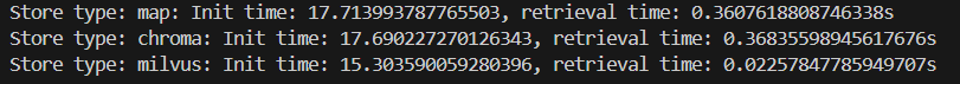

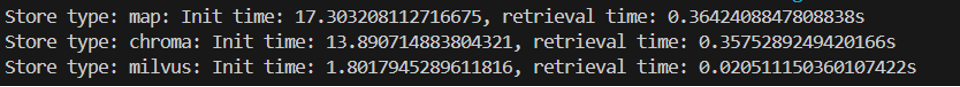


根据耗时数据我们可以看到，由于系统多次运行程序时存在性能误差，使用两种向量数据库实现数据持久化存储对于系统启动性能均有不同程度的性能提升。在第一次启动时，三种存储类型的系统初始化时间相差不大，均在16~17s，而在系统二次启动时，初始化时间便拉开了差距。其中，使用ChromaDB对于系统启动效率的提升幅度较小，节省时间约21%，使用Milvus则对系统二次启动性能有较大的提升，启动时间节省约87.36%。由此可见，使用存储后端可以在系统二次启动时节省时间，且使用持久化存储后，系统便无需重新执行文档分块和文档嵌入，从而节约一定的算力资源。

[相关视频：video\12_1.mp4](video/12_1.mp4)


### 存储数据管理

LazyLLM 提供存储数据管理接口，通过在创建 document 时传入 manager=True 或 manager='ui' ，可以实现存储数据的增删改查功能。

In [ ]:
import lazyllm

document = lazyllm.Document(dataset_path='/path/to/your/document',
                            embed=lazyllm.OnlineEmbeddingModule(),
                            store_conf=milvus_store_conf,
                            manager=True) # manager='ui'

document.start().wait()
doc_manager_url = document.manager.url 
# doc_manager_url 应为形如 http://127.0.0.1:12345/generate 的地址
# 有效部分为 http://127.0.0.1:12345

[相关视频：video\12_2_doc_manager.mp4](video/12_2_doc_manager.mp4)

[相关视频：video\12_3_doc_manager.mp4](video/12_3_doc_manager.mp4)


- manager=True 

启动文档管理服务，用户可以通过多种接口实现文档管理功能，包括查询文档、查询节点组、新增或更新文档、查询或更新文档元数据等功能。

- manager='ui' 

提供更直观的界面，方便开发者直接在页面中查看分组列表、查看分组文件列表、上传和删除文件。两种情况都支持用户通过接口对文档进行增删改查，您可以通过 http://127.0.0.1:12345/docs 访问 Swagger API 接口文档获取更详细的接口文档。如需对文档进行增删，通过 http 协议进行指定操作即可。具体来说，document manager提供了以下接口

> API文档  GET                  /docs
>
> 列出文件 GET                 /list_files  
>
> 上传文件 POST               /upload_files
>
> 添加文件 POST               /add_files
>
> 删除文件 POST               /delete_files
>
> 添加元文件 POST            /add_metadata
>
> 删除元信息 POST            /delete_metadata_item
>
> 新增或更新元信息           /update_or_create_metadata_keys
>
> 重置元信息                    /reset_metadata

下面给出一个上传文件的简单例子，您只需根API文档拼接相关 url 即可：

In [ ]:
import io
import json
import requests

doc_manager_url = '127.0.0.1:12345' # 将此处改为您的url

# 获取文档库文档数量
res = requests.get(f"http://{doc_manager_url}/list_files")
data = res.json().get('data')
# data 为形如
# [['36e494cd803e2eb0d04772a08277174ea13c1e9ba8a001c012def7437afc7d74', 
#   'test.txt', 
#   'file_path', 
#   '2025-03-07 12:03:52', 
#   '2025-03-07 12:03:52', 
#   '{"docid": "36e494cd803e2eb0d04772a08277174ea13c1e9ba8a001c012def7437afc7d74", 
#   "lazyllm_doc_path": "file_path"}', 
#   'success',
#    1]]
print(len(data))

# 上传虚拟文档
# 此处会将该文档上传至 Document 初始化时的 dataset_path 路径下
# 注意，再 'test1.txt' 的位置填入文件名即可
files = [('files', ('test1.txt', io.BytesIO(b"file1 content"), 'text/plain')),
        ('files', ('test2.txt', io.BytesIO(b"file2 content"), 'text/plain'))]

# 参数，override设置为true表示覆盖原有同名文档，metadatas为文档元信息，您可以根据需要上传
data = dict(override='true', metadatas=json.dumps([{"version": "v1.2"}，{"version": "v1.3"}]), user_path='/path')
# 将参数拼接到 url
url = f"http://{doc_manager_url}/upload_files" + ('?' + '&'.join([f'{k}={v}' for k, v in data.items()]))
response = requests.post(url, files=files)

# 获取文档库文档数量
res = requests.get(f"http://{doc_manager_url}:39598/list_files?details=False")
data = res.json().get('data')
print(len(data))

假设文档库只有一个文件，则上述代码输出应满足：

```bash
 1
 3
```

# 二、构建高效索引提升检索性能

在本节课之前，我们学习了创建多节点组并采用多路召回的方式优化检索效果，该策略的加入对召回阶段的性能有着更高的要求。本节我们将通过几组实践向您展示索引的强大，通过手把手教您使用LazyLLM的自定义索引组件创建高效索引、从0开始使用高效的Milvus数据库、在LazyLLM中使用最简洁的方式使用Milvus数据库，并在最后向您介绍RAG系统中的一些工程优化技巧（如缓存、并行机制），全方位向您介绍如何提升检索阶段的效率。

## 实践二 构建高效索引，提升检索速度

按照之前介绍，目前LazyLLM内置的一些索引（Index），如DefaultIndex、_FileNodeIndex 和 SmartEmbeddingIndex。其中 DefaultIndex 是默认 Index，支持 embedding 和 text 两种类型，按顺序进行相似度计算，并返回 topk 的nodes，即线性搜索，线性搜索的时间复杂度高，不适合大型数据集的检索；_FileNodeIndex 支持通过 file 获取对应的 nodes；SmartEmbeddingIndex 支持通过 Milvus 接口实现高速向量检索。

### 小试牛刀，使用IndexBase构建字典树

由于LazyLLM内置的线性搜索检索效率较低，本实践将介绍如何使用LazyLLM构建自定义索引，提升向量检索速度。在LazyLLM中，所有的索引均使用IndexBase组件创建，随后索引组件可被注册在Document当中，并在后续的检索过程中使用。我们首先拿11讲中查字典的例子，使用IndexBase创建一个字典树，以实现单词高效查询。

#### Index实现

使用IndexBase创建自定义索引需要实现三个方法：索引更新（update）、节点移除（remove）以及检索（query）。字典树是一个多叉树，我们根据其定义创建字典树索引（完整代码见[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter12/retriever_with_custom_index_trie_tree.py#L16)）：

In [ ]:
from typing import Dict, List, Optional

import lazyllm
from lazyllm.tools.rag import IndexBase, StoreBase, DocNode
from lazyllm.common import override

# 定义字典树节点
class TrieNode:
    def __init__(self):
        self.children: Dict[str, TrieNode] = {}    # 子节点集合 key为字母
        self.is_end_of_word: bool = False    # 完整单词标记
        self.uids: set[str] = set()    # 保存当前节点完整单词uid

class TrieTreeIndex(IndexBase):
    def __init__(self, store: 'StoreBase'):
        self.store = store    # 绑定存储
        self.root = TrieNode()    # 定义根节点
        self.uid_to_word: Dict[str, str] = {}    # uid--单词映射关系

    @override
    def update(self, nodes: List['DocNode']) -> None:
        if not nodes or nodes[0]._group != 'trie_tree':
            return
        # 对每个单词建立索引
        for n in nodes:
            uid = n._uid
            word = n.text
            self.uid_to_word[uid] = word
            node = self.root
            # 从单词首字母遍历每个字母
            for char in word:
                # 获取节点对应字母的孩子分支
                node = node.children.setdefault(char, TrieNode())
            node.is_end_of_word = True
            node.uids.add(uid)

    @override
    def remove(self, uids: List[str], group_name: Optional[str] = None) -> None:
        """从索引中删除单词"""
        if group_name != 'trie_tree':
            return
        for uid in uids:
            word = self.uid_to_word.pop(uid, None)
            if not word:
                continue
            self._remove(self.root, word, 0, uid)
            
    def _remove(self, node: TrieNode, word: str, index: int, uid: str) -> bool:
        if index == len(word):
            if uid not in node.uids:
                return False
            node.uids.remove(uid)
            node.is_end_of_word = bool(node.uids)
            return not node.children and not node.uids
        char = word[index]
        child = node.children.get(char)
        if not child:
            return False
        should_delete = self._remove(child, word, index + 1, uid)
        if should_delete:
            del node.children[char]
            return not node.children and not node.uids
        return False

    @override
    def query(self, query: str, group_name: str, **kwargs) -> List[str]:
        node = self.root
        # 遍历query中单词的每个字母，从字典树查找是否存在单词
        for char in query:
            node = node.children.get(char)
            if node is None:
                return []
        return self.store.get_nodes(group_name=group_name, uids=list(node.uids)) if node.is_end_of_word else []

上面的代码里定义了基于字典树的标量索引，首先该 class 继承自 IndexBase，update 和 remove方法用于新增和删除对应单词的索引。方法 query用于查找字典树中是否包含目标单词，若字典树中包含该单词，则返回单词对应的节点。

>注意：使用默认存储（内存存储）的情况下，节点的更新与删除会自动关联Index的更新与删除。

#### **Index 注册**

上面定义好 Index 组件之后，就需要把它注册进 LazyLLM 的框架里面了。注册的时候我们通过 key-value 的形式进行注册。

In [ ]:
from lazyllm.tools.rag import Document

# 通过实例化对象进行注册
document = Document(dataset_path="dataset_path", manager=False)
# 这里document.get_store() 会透传给 TrieTreeIndex，如果您定义的Index初始化不接收任何数据，则无需传入
document.register_index("trie_tree", TrieTreeIndex, document.get_store())

在上面的代码中，先实例化了一个 Document 对象，然后通过该 Document 实例化对象进行 Index 组件的注册，注册时需要指定一个字符串类型的 key，即注册index的名字，这里是 “trie_tree”，然后是定义好的类 TrieTreeIndex， 最后指定需要的初始化参数，也就是自定义 Index 类的 __init__ 方法需要接收的参数。您可以传入任何常量作为初始化参数，也可以传入 document.get_store() 或 document.get_embed() ,  这两个是 Document 里延迟初始化提供的参数，分别表示存储实例和嵌入模型。如果没有参数，则无需传入任何值。

#### **Index 使用**

定义并注册 Index 之后即可在检索器Retriever中使用，我们准备一个庞大的词表，其中包含37w个英文字符串（大多数为英文单词）。

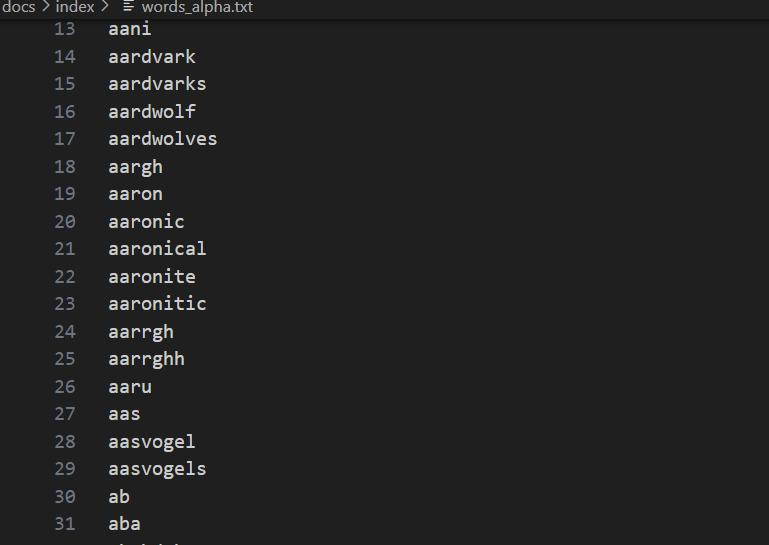

我们按照上面的方式，同样定义一个线性搜索索引 LinearIndex ，注意，这里仅为了展示线性搜索和字典树的性能差异，实际生产中因为性能需求，并不建议使用线性索引进行搜索，完整代码见[链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter12/retriever_with_custom_index_trie_tree.py#L82)：

In [ ]:
class LinearSearchIndex(IndexBase):
    def __init__(self):
        self.nodes = []

    @override
    def update(self, nodes: List['DocNode']) -> None:
        if not nodes or nodes[0]._group != 'linear':
            return
        for n in nodes:
            self.nodes.append(n)

    @override
    def remove(self, uids: List[str], group_name: Optional[str] = None) -> None:
        if group_name != 'linear':
            return
        for uid in uids:
            for i, n in enumerate(self.nodes):
                if n._uid == uid:
                    del self.nodes[i]
                    break

    @override
    def query(self, query: str, **kwargs) -> List[str]:
        # 假设每个单词只出现一次，只进行精准匹配
        res = []
        for n in self.nodes:
            if n.text == query:
                res.append(n)
                break
        return res

定义索引性能测试程序：

In [ ]:
def test_trie_index(queries: list[str]):
    dataset_path = os.path.join(DOC_PATH, "index")
    docs1 = lazyllm.Document(dataset_path=dataset_path, embed=embedding_model)
    # 创建节点组
    docs1.create_node_group(name='linear', transform=(lambda d: d.split('\r\n')))
    docs1.create_node_group(name='tree', transform=(lambda d: d.split('\r\n')))
    # 注册索引
    docs1.register_index("trie_tree", TrieTreeIndex, docs1.get_store())
    docs1.register_index("linear_search", LinearSearchIndex)
    # 创建检索器，指定对应索引类型
    retriever1 = lazyllm.Retriever(docs1, group_name="linear", index="linear_search", topk=1)
    retriever2 = lazyllm.Retriever(docs1, group_name="tree", index="trie_tree", topk=1)
    # 检索器初始化
    retriever1.start()
    retriever2.start()
    for query in queries:
        st = time.time()
        res = retriever1(query)
        et = time.time()
        LOG.info(f"query: {query}, linear time: {et - st}, linear res: {res[0].text}")
    
        st = time.time()
        res = retriever2(query)
        et = time.time()
        LOG.info(f"query: {query}, trie time: {et - st}, trie res: {res[0].text}")

test_trie_index(["a", "lazyllm", "zwitterionic"]) 

代码运行结果：

```bash
query: a, linear time: 9.894371032714844e-05, linear res: a
query: a, trie time: 7.939338684082031e-05, trie res: a
query: lazyllm, linear time: 0.04016876220703125, linear res: lazyllm
query: lazyllm, trie time: 0.00011754035949707031, trie res: lazyllm
query: zwitterionic, linear time: 0.08771300315856934, linear res: zwitterionic
query: zwitterionic, trie time: 0.00011014938354492188, trie res: zwitterionic
```

可以看到字典树与线性搜索均成功搜索对应的节点，但所用时间有着较为明显的差别：

线性搜索随着检索单词在词表中越往后，其耗时越来越久，而字典树的检索时间较为稳定。在37w词表中的最后一个单词检索过程中，线性搜索耗时0.0877s，字典树仅耗时0.0001s，时间节省了99.89%！因此，合理设计索引能够大大提升系统的检索效率。

[相关视频：video\12_4.mp4](video/12_4.mp4)


### 结合场景，自己编写HNSW索引

在RAG场景中，往往建立高性能的ANN向量索引，以加速向量检索。根据上节课的介绍，相比大家对HNSW有了一定的了解，接下来我们按照上面构建索引的思路，同样构建一个HNSW索引，并对比LazyLLM内置的cosine相似度+默认索引情况下向量检索的速度。

HNSW索引的实现依赖hnswlib库，热门的向量数据库Milvus底层的ANN库之一就是hnswlib, 为milvus提供HNSW检索。具体代码如下（[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter12/retriever_with_custom_index_hnsw.py#L19)）：

In [ ]:
class HNSWIndex(IndexBase):
    def __init__(
            self,
            embed: Dict[str, Callable],
            store: StoreBase,
            max_elements: int = 10000, # 定义索引最大容量
            ef_construction: int = 200,    # 平衡索引构建速度和搜索准确率，越大准确率越高但是构建速度越慢
            M: int = 16,    # 表示在建表期间每个向量的边数目量，M越高，内存占用越大，准确率越高，同时构建速度越慢
            dim: int = 1024, # 向量维度
            **kwargs
        ):
        self.embed = embed
        self.store = store
        # 由于hnswlib中的向量id不能为str，故建立label用于维护向量编号
        # 创建字典以维护节点id和hnsw中向量id的关系
        self.uid_to_label = {}
        self.label_to_uid = {}
        self.next_label = 0
        #初始化hnsw_index
        self._index_init(max_elements, ef_construction, M, dim)

    def _index_init(self, max_elements, ef_construction, M, dim):
        # hnswlib支持多种距离算法：l2、IP内积和cosine
        self.index = hnswlib.Index(space='cosine', dim=dim)
        self.index.init_index(
            max_elements=max_elements,
            ef_construction=ef_construction,
            M=M,
            allow_replace_deleted=True
        )
        self.index.set_ef(100) # 设置搜索时的最大近邻数量，较高值会导致更好的准确率，但搜索速度会变慢
        self.index.set_num_threads(8) # 设置在批量搜索和构建索引过程中使用的线程数

    @override
    def update(self, nodes: List['DocNode']):
        if not nodes or nodes[0]._group != 'block':
            return
        # 节点向量化，这里仅展示使用默认的embedding model
        parallel_do_embedding(self.embed, [], nodes=nodes, group_embed_keys={'block': ["__default__"]})
        vecs = []    # 向量列表
        labels = []    # 向量id列表
        for node in nodes:
            uid = str(node._uid)
            # 记录uid和label的关系，若为新的uid，则写入next_label
            if uid in self.uid_to_label:
                label = self.uid_to_label[uid]
            else:
                label = self.next_label
                self.uid_to_label[uid] = label
                self.next_label += 1
            # 取默认embedding结果
            vec = node.embedding['__default__'] 
            vecs.append(vec)
            labels.append(label)
            self.label_to_uid[label] = uid
        
        # 根据向量建立hnsw索引
        data = np.vstack(vecs)
        ids  = np.array(labels, dtype=int)
        self.index.add_items(data, ids)

    @override
    def remove(self, uids, group_name=None):
        """
        标记删除一批 uid 对应的向量，并清理映射
        """
        if group_name != 'block':
            return
        for uid in map(str, uids):
            if uid not in self.uid_to_label:
                continue
            label = self.uid_to_label.pop(uid)
            self.index.mark_deleted(label)
            self.label_to_uid.pop(label, None)

    @override
    def query(
        self,
        query: str,
        topk: int,
        embed_keys: List[str],
        **kwargs,
    ) -> List['DocNode']:
        # 生成查询向量
        parts = [self.embed[k](query) for k in embed_keys]
        qvec = np.concatenate(parts)
        # 调用hnsw knn_query方法进行向量检索
        labels, distances = self.index.knn_query(qvec, k=topk, num_threads=self.index.num_threads)
        results = []
        #取检索topk
        for lab, dist in zip(labels[0], distances[0]):
            uid = self.label_to_uid.get(lab)
            results.append(uid)
            if len(results) >= topk:
                break
        # 从store获取对应uid的节点
        return self.store.get_nodes(group_name='block', uids=results) if len(results) > 0 else []


def test_hnsw_index():
    dataset_path = os.path.join(DOC_PATH, "test")
    docs1 = lazyllm.Document(dataset_path=dataset_path, embed=embedding_model)
    docs1.create_node_group(name='block', transform=(lambda d: d.split('\n')))
    docs1.register_index("hnsw", HNSWIndex, docs1.get_embed(), docs1.get_store())
    retriever1 = lazyllm.Retriever(docs1, group_name="block", similarity="cosine", topk=3)
    retriever2 = lazyllm.Retriever(docs1, group_name="block", index="hnsw", topk=3)
    retriever1.start()
    retriever2.start()
    q = "证券监管？"
    st = time.time()
    res = retriever1(q)
    et = time.time()
    context_str = "\n---------\n".join([r.text for r in res])
    LOG.info(f"query: {q}, default time: {et - st}, default res:\n {context_str}")

    st = time.time()
    res = retriever2(q)
    et = time.time()
    context_str = "\n---------\n".join([r.text for r in res])
    LOG.info(f"query: {q}, HNSW time: {et - st}, HNSW res: \n{context_str}")

test_hnsw_index()

运行结果如下所示：

```bash
query: 证券监管？, default time: 0.5182957649230957, default res:
 金融监管部门的保护措施
---------
为规范证券公司资金账户管理工作，防范业务风险，保护客户合法权益，根据《中
---------
 为贯彻落实《证券经纪业务管理办法》 ，引导证券公司规范开展证券经纪业务，协
query: 证券监管？, HNSW time: 0.021764516830444336, HNSW res: 
金融监管部门的保护措施
---------
 为贯彻落实《证券经纪业务管理办法》 ，引导证券公司规范开展证券经纪业务，协
---------
为规范证券公司资金账户管理工作，防范业务风险，保护客户合法权益，根据《中

可以看到，使用默认的cosine相似度和默认索引进行向量检索用时0.518s，而使用自己实现的HNSW索引执行向量检索耗时0.022s，时间节省约95%。这个结论和标量索引实践一致，即通过建立高效索引，“以空间换时间”，可以大大降低计算量，提高检索效率。

## 实践三 从零开始，使用高性能向量数据库Milvus

向量索引很强大，但是从0开始手搓一个高性能索引成本比较高。细心的你一定发现了——在先前的存储配置中，Milvus向量数据库的配置参数中已经包含了索引相关的配置，没错！向量数据库早已把这些高性能的向量索引，实际研发过程中，我们只需要使用这些高性能的向量数据库，便可实现高性能的向量检索！

### 原生Milvus使用方式简介

我们首先了解一下本次实践的主角——高性能向量数据库Milvus的原生基础使用方法，包含milvus的安装以及基本功能的使用（初始化、数据注入、数据检索）。

#### 安装

在本次实践中，我们使用 Milvus Lite，它是`pymilvus` 中包含的一个 python 库，可以嵌入到应用程序中。Milvus 还支持在Docker和Kubernetes上部署，适用于生产用例。运行下方命令即可完成pymilvus的安装。

In [ ]:
pip install -U pymilvus

#### 使用

首先我们使用以下代码创建一个milvus客户端。

In [ ]:
from pymilvus import MilvusClient
# 创建milvus客户端，传入本地数据库的存储路径，若路径不存在则创建
client = MilvusClient("dbs/origin_milvus.db")

在 Milvus 中，我们需要一个 Collections 来存储向量及其相关元数据。它相当于传统 SQL 数据库中的表格。创建 Collections 时，可以定义 Schema 和索引参数来配置向量规格，如维度（dimension）、索引类型（index_params）和距离度量（metric_type）等。[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter12/use_original_milvus.py#L8)。

In [ ]:
# 初始化阶段，如果已存在同名collection，则先删除
if client.has_collection(collection_name="demo_collection"):
    client.drop_collection(collection_name="demo_collection")

client.create_collection(
    collection_name="demo_collection",
    dimension=1024,
)

> 注：create_collection支持更多的入参，如主键列名primary_field_name、向量列名vector_field_name、向量索引参数index_params、相似度参数metric_type等，此处仅介绍基本用法，其余均使用默认参数。

随后准备文档切片，进行向量化后按照milvus接受的格式创建数据集，并注入数据库中，这里我们额外增加了一个字段subject（学科），用于充当数据的metadata。[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter12/use_original_milvus.py#L16)。

In [ ]:
docs = [
    "Artificial intelligence was founded as an academic discipline in 1956.",
    "Alan Turing was the first person to conduct substantial research in AI.",
    "Born in Maida Vale, London, Turing was raised in southern England.",
]
vecs =[embedding_model(doc) for doc in docs] 
data = [
    {"id": i, "vector": vecs[i], "text": docs[i], "subject": "history"}
    for i in range(len(vecs))
]
# 数据注入
res = client.insert(collection_name="demo_collection", data=data)
print(f"Inserted data into client:\n {res}")

进行query检索时，同样需要先将query进行向量化，随后在client中调用search方法，指定对应的collection以及检索数量，并且支持指定输出哪些字段（output_fields）。[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter12/use_original_milvus.py#L30)。

In [ ]:
query = "Who is Alan Turing?"
# query向量化
q_vec = embedding_model(query)
# 检索
res = client.search(
    collection_name="demo_collection",    # 指定collection
    data=[q_vec],
    limit=2,    # 指定检索数量（top_k）
    output_fields=["text", "subject"],    #指定检索结果中包含的字段
)
print(f"Query: {query} \nSearch result:\n {res}")

milvus不仅支持简单高效的向量检索，同时支持使用元数据作为过滤字段，实现标量索引+向量索引的符合检索。下面的代码中，我们同样创建3个文段，并在数据注入是设置subject为不同的学科。在检索方法search的入参中，我们输入filter参数，以设置期望过滤的数据。[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/a09a84cdf0585a5c9d52af6db0e965be95d03123/rag/codes/chapter12/use_original_milvus.py#L43)。

In [ ]:
docs = [
    "Machine learning has been used for drug design.",
    "Computational synthesis with AI algorithms predicts molecular properties.",
    "DDR1 is involved in cancers and fibrosis.",
]
vecs =[embedding_model(doc) for doc in docs]
data = [
    {"id": 3 + i, "vector": vecs[i], "text": docs[i], "subject": "biology"}
    for i in range(len(vecs))
]
client.insert(collection_name="demo_collection", data=data)
res = client.search(
    collection_name="demo_collection",
    data=[embedding_model("tell me AI related information")],
    filter="subject == 'biology'",    # 期望过滤的字段
    limit=2,
    output_fields=["text", "subject"],
)
print(f"Filter Query: {query} \nSearch result:\n {res}")

[相关视频：video\12_5.mp4](video/12_5.mp4)


我们结合以上使用方式，结合LazyLLM的其他组建重新搭建一个简易的RAG系统（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/282ffb74e3fe7c5c28df4ad498ed972973dfbc62/rag/codes/chapter12/rag_with_original_milvus.py#L1)）：

In [ ]:
import os

import lazyllm
from lazyllm.tools.rag import SimpleDirectoryReader, SentenceSplitter
from lazyllm.tools.rag.doc_node import MetadataMode

from pymilvus import MilvusClient

from online_models import embedding_model, llm, rerank_model

DOC_PATH = os.path.abspath("docs")

###################### 文件入库 ###################################
# milvus client初始化
client = MilvusClient("dbs/rag_milvus.db")
if client.has_collection(collection_name="demo_collection"):
    client.drop_collection(collection_name="demo_collection")

client.create_collection(
    collection_name="demo_collection",
    dimension=1024,
)

# 加载本地文件，并解析 -- block切片 -- 向量化 -- 入库
dataset_path = os.path.join(DOC_PATH, "test")
docs = SimpleDirectoryReader(input_dir=dataset_path)()
block_transform = SentenceSplitter(chunk_size=256, chunk_overlap=25)

nodes = []
for doc in docs:
    nodes.extend(block_transform(doc))

# 切片向量化
vecs = [embedding_model(node.get_text(MetadataMode.EMBED)) for node in nodes]
data = [
    {"id": i, "vector": vecs[i], "text": nodes[i].text}
    for i in range(len(vecs))
]
#数据注入
res = client.insert(collection_name="demo_collection", data=data)

###################### 检索问答 ###################################
query = "证券管理的基本规范？"

# 检索与生成
prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
        根据以下资料回答问题：\
        {context_str} \n '
llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extro_keys=['context_str']))

q_vec = embedding_model(query)
res = client.search(
    collection_name="demo_collection",
    data=[q_vec],
    limit=12,
    output_fields=["text"],
)

# 提取检索结果
contexts = [res[0][i].get('entity').get("text", "") for i in range(len(res[0]))]

# 重排
rerank_res = rerank_model(text=query, documents=contexts, top_n=3)
rerank_contexts = [contexts[res[0]] for res in rerank_res]

context_str = "\n-------------------\n".join(rerank_contexts)

res = llm({"query": query, "context_str": context_str})
print(res)

在上述代码中，我们首先使用原生的使用方式定义了milvus client，随后使用LazyLLM自带的文档解析器提取文档内容，并转换为切片，向量化后注入向量数据库中。随后进行query检索，提取检索内容并执行重排序后，给到大模型进行回答。

[相关视频：video\12_6.mp4](video/12_6.mp4)

### 在LazyLLM中使用Milvus

从上述的实践内容中我们不难发现，milvus可以实现持久化存储、检索性能强。但是原生milvus的使用方式确实有些复杂，用户需要花较大的成本从头学习如何使用一个向量数据库。这对于开发者来说多少有些“折腾”。索性LazyLLM已经将Milvus完美适配，按照先前介绍的，只需要进行简单的存储及索引后端配置，便可轻松将milvus接入到RAG系统当中。具体配置方法是需要在上述存储后端配置store_conf中额外添加字段 'indices' ，indices是一个python字典，key 是索引类型名称，value 是该索引类型所需要的参数，具体配置如下：

In [ ]:
store_conf = {
    'type': 'map',
    'indices': {
        'smart_embedding_index': {
            'backend': 'milvus',                        # 设定索引使用Milvus后端
              'kwargs': {
                'uri': 'dbs/test.db',               # Milvus数据存储地址
                  'index_kwargs': {        
                    'index_type': 'HNSW',                # 设置索引类型
                    'metric_type': 'COSINE',       # 设置度量类型
                }
            },
        },
    },
}

- key: 'smart_embedding_index'（使用milvus向量数据库内置向量索引，以实现高效向量检索）
- values: 
  - 'backend': 索引后端，当前仅支持传入'milvus'，已使用Milvus向量数据库。
  - 'kwargs'：选择对应索引后端时，额外的配置项，选择milvus时，配置项与存储后端使用milvus一致，均为uri和index_kwargs。

Milvus 支持多种索引方式，一般来说浮点索引（即对稠密向量进行索引）的使用场景较多，适用于大规模数据的语义检索，二进制索引和稀疏索引适用于数据集较小的情况，可以保证较高的召回率。每种索引方式都有对应的推荐度量方式，您可以根据需求按照下表进行选择：

| 索引方式   | 具体类型                                                                                                                                   | 度量类型                     |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------|------------------------------|
| 浮点索引   | - 平面<br>- IVF_FLAT<br>- IVF_SQ8<br>- IVF_PQ<br>- GPU_IVF_FLAT<br>- GPU_IVF_PQ<br>- HNSW<br>- DISKANN                                     | - 欧氏距离 (L2)<br>- 内积 (IP)<br>- 余弦相似度 (COSINE) |
| 二进制索引 | - BIN_FLAT<br>- BIN_IVF_FLAT                                                                                                               | - Jaccard (JACCARD)<br>- 哈明 (HAMMING)             |
| 稀疏索引   | - SPARSE_INVERTED_INDEX<br>- SPARSE_WAND                                                                                                   | - 内积（IP）                 |

我们根据以上milvus配置，使用LazyLLM内置的SmartEmbeddingIndex实现Milvus的索引接入，并同样与使用默认索引的Retriever比较检索速度（完整代码见[Github链接](https://github.com/LazyAGI/Tutorial/blob/patch-1/rag/codes/chapter12/retriever_with_custom_index_hnsw.py#L118)）：

In [ ]:
import os
import time

import lazyllm
from lazyllm import LOG

from online_models import embedding_model

DOC_PATH = os.path.abspath("docs")

milvus_store_conf = {
    'type': 'map',
    'indices': {
        'smart_embedding_index': {
            'backend': 'milvus',
            'kwargs': {
                'uri': "dbs/test_map_milvus.db",
                'index_kwargs': {
                    'index_type': 'HNSW',
                    'metric_type': 'COSINE',
                }
            },
        },
    },
}
dataset_path = os.path.join(DOC_PATH, "test")

docs = lazyllm.Document(dataset_path=dataset_path, embed=embedding_model, store_conf=milvus_store_conf)

# 使用默认索引
retriever1 = lazyllm.Retriever(docs, group_name="MediumChunk", topk=6, similarity="cosine")
# 使用milvus内置HNSW索引
retriever2 = lazyllm.Retriever(docs, group_name="MediumChunk", topk=6, index='smart_embedding_index')
retriever1.start()
retriever2.start()

q = "证券监管？"
st = time.time()
res = retriever1(q)
et = time.time()
LOG.info(f"query: {q}, default time: {et - st}")

st = time.time()
res = retriever2(q)
et = time.time()
LOG.info(f"query: {q}, milvus time: {et - st}")

在store_conf的配置中，存储后端和索引后端是独立的两部分，但是如果存储类型选择milvus的情况下，由于kwargs中已经包含了索引配置信息，因此无需额外配置indices，即可实现内置的向量检索。

可以看到，使用 Milvus 时，和将 Milvus 用作存储后端一致，将索引配置indices传入 store_conf ，然后在 Retriever 中指定 index='smart_embedding_index' 即可。相比于原生的使用方式，使用store_conf使向量数据库的使用更加简单，代码也更加简洁可读。程序运行的结果如下：

```bash
query: 证券监管？, default time: 0.16447973251342773
query: 证券监管？, milvus time: 0.02178812026977539
```

使用LazyLLM内置的Milvus执行检索相比默认的向量索引，检索时间节省约86.75%。使用 Milvus 作为索引后端，基于多 embedding 召回策略构建 RAG 系统代码如下所示，下方代码展示了同时使用稠密和稀疏检索的方式：

In [ ]:
import lazyllm
from lazyllm import bind, deploy

milvus_store_conf = {
    'type': 'milvus',
    'kwargs': {
        'uri': "milvus.db",
        'index_kwargs': [
            {
                'embed_key': 'bge_m3_dense',
                'index_type': 'IVF_FLAT',
                'metric_type': 'COSINE',
            },
            {
                'embed_key': 'bge_m3_sparse',
                'index_type': 'SPARSE_INVERTED_INDEX',
                'metric_type': 'IP',
            }
        ]
    },
}

bge_m3_dense = lazyllm.TrainableModule('bge-m3')
bge_m3_sparse = lazyllm.TrainableModule('bge-m3').deploy_method((deploy.AutoDeploy, {'embed_type': 'sparse'}))
embeds = {'bge_m3_dense': bge_m3_dense, 'bge_m3_sparse': bge_m3_sparse}
document = lazyllm.Document(dataset_path='/path/to/your/document',
           embed=embeds,
           store_conf=milvus_store_conf)

document.create_node_group(name="block", transform=lambda s: s.split("\n") if s else '')
bge_rerank = lazyllm.TrainableModule("bge-reranker-large")

with lazyllm.pipeline() as ppl:
    with lazyllm.parallel().sum as ppl.prl:
        ppl.prl.retriever1 = lazyllm.Retriever(doc=document,
                         group_name="block",
                         embed_keys=['bge_m3_dense'],
                         topk=3)
        ppl.prl.retriever = lazyllm.Retriever(doc=document,
                         group_name="block",
                         embed_keys=['bge_m3_sparse'],
                         topk=3)
    ppl.reranker = lazyllm.Reranker(name='ModuleReranker',model=bge_rerank, topk=3) | bind(query=ppl.input)
    ppl.formatter = (
      lambda nodes, query: dict(
          context_str=[node.get_content() for node in nodes],
          query=query)
    ) | bind(query=ppl.input)
    
    ppl.llm = lazyllm.OnlineChatModule().prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))
webpage = lazyllm.WebModule(ppl, port=23492).start().wait()

[相关视频：video\12_7.mp4](video/12_7.mp4)

结合之前介绍的存储配置，我们将第七讲中的RAG系统进行存储和索引的全面优化，全面提升系统的执行效率，代码如下（[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/patch-4/rag/codes/chapter12/rag_use_milvus_store.py)）：

In [ ]:
import os

import lazyllm
from lazyllm import Reranker

from online_models import embedding_model, llm, rerank_model    # 使用线上模型

DOC_PATH = os.path.abspath("docs")

# milvus存储和索引配置
milvus_store_conf = {
    'type': 'milvus',
    'kwargs': {
        'uri': "dbs/milvus1.db",
        'index_kwargs': {
        'index_type': 'HNSW',
        'metric_type': 'COSINE',
        }
    }
}
dataset_path = os.path.join(DOC_PATH, "test")

# 定义Document，传入配置以使用milvus存储及检索
docs = lazyllm.Document(dataset_path=dataset_path, embed=embedding_model, store_conf=milvus_store_conf)
#创建句子节点组
docs.create_node_group(name='sentence', parent="MediumChunk", transform=(lambda d: d.split('。')))
#创建MediumChunk、sentence节点组多路召回，
retriever1 = lazyllm.Retriever(docs, group_name="MediumChunk", topk=6, index='smart_embedding_index')
retriever2 = lazyllm.Retriever(docs, group_name="sentence", target="MediumChunk", topk=6, index='smart_embedding_index')
retriever1.start()
retriever2.start()
#创建reranker
reranker = Reranker('ModuleReranker', model=rerank_model, topk=3)

prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
        根据以下资料回答问题：\
        {context_str} \n '
llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extro_keys=['context_str']))

query = "证券管理有哪些准则？"

nodes1 = retriever1(query=query)
nodes2 = retriever2(query=query)
rerank_nodes = reranker(nodes1 + nodes2, query)
context_str = "\n======\n".join([node.get_content() for node in rerank_nodes])
print(f"context_str: \n{context_str}")
res = llm({"query": query, "context_str": context_str})
print(res)

Milvus不仅支持本地db文件链接，同时支持远程服务器端点的接入。

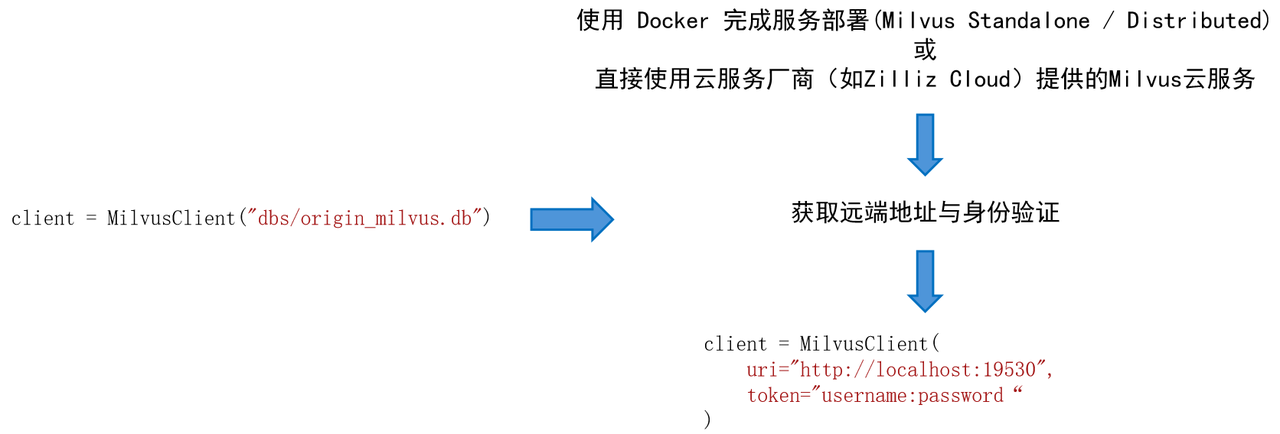

例如，我们期望在Linux系统上部署Milvus Standalone服务。

- 安装Docker，并根据 Milvus 官方文档检查硬件与软件要求。
- 在Docker中安装Milvus，安装脚本：

In [ ]:
# 下载安装脚本
curl -sfL https://raw.githubusercontent.com/milvus-io/milvus/master/scripts/standalone_embed.sh -o standalone_embed.sh

# 启动Docker容器
bash standalone_embed.sh start

- 安装结果：
  - 名为 Milvus 的 docker 容器在19530端口启动。要更改 Milvus 的默认配置，需将设置添加到当前文件夹中的user.yaml文件，然后重新启动服务。
  - Milvus 数据卷被映射到当前文件夹中的volumes/milvus。

## 实践四 工程优化技巧，缓存与并行检索

在先前的第11讲中我们提到了一些工程优化技巧，例如缓存机制、多任务并行等。接下来我们分别进行实践。

### 使用K-V缓存

本次实践使用简单的k-v dict模拟缓存机制，我们搭建一个从RAG系统启动至检索的过程，并设置kv字典用于保存检索过的query与节点集合，并测试有无缓存机制时系统的检索时间：

In [ ]:
milvus_store_conf = {
    'type': 'map',
    'indices': {
        'smart_embedding_index': {
        'backend': 'milvus',
        'kwargs': {
            'uri': "dbs/test_cache.db",
            'index_kwargs': {
                'index_type': 'HNSW',
                'metric_type': 'COSINE',
            }
        },
        },
    },
}
dataset_path = os.path.join(DOC_PATH, "test")

docs = lazyllm.Document(
    dataset_path=dataset_path,
    embed=embedding_model,
    store_conf=milvus_store_conf
)
docs.create_node_group(name='sentence', parent="MediumChunk", transform=(lambda d: d.split('。')))

retriever1 = lazyllm.Retriever(docs, group_name="MediumChunk", topk=6, index='smart_embedding_index')
retriever2 = lazyllm.Retriever(docs, group_name="sentence", target="MediumChunk", topk=6, index='smart_embedding_index')
retriever1.start()
retriever2.start()

reranker = Reranker('ModuleReranker', model=rerank_model, topk=3)

# 设置固定query
query = "证券管理的基本规范？"

# 运行5次没有缓存机制的检索流程，并记录时间
time_no_cache = []
for i in range(5):
    st = time.time()
    nodes1 = retriever1(query=query)
    nodes2 = retriever2(query=query)
    rerank_nodes = reranker(nodes1 + nodes2, query)
    et = time.time()
    t = et - st
    time_no_cache.append(t)
    print(f"No cache 第 {i+1} 次查询耗时：{t}s")

# 定义dict[list]，存储已检索的query和节点集合，实现简易的缓存机制
kv_cache = defaultdict(list)
for i in range(5):
    st = time.time()
    #如果query未在缓存中，则执行正常的检索流程，若query命中缓存，则直接取缓存中的节点集合
    if query not in kv_cache:
        nodes1 = retriever1(query=query)
        nodes2 = retriever2(query=query)
        rerank_nodes = reranker(nodes1 + nodes2, query)
        # 检索完毕后，缓存query及检索节点
        kv_cache[query] = rerank_nodes
    else:
        rerank_nodes = kv_cache[query]
    et = time.time()
    t = et - st
    time_no_cache.append(t)
    print(f"KV cache 第 {i+1} 次查询耗时：{t}s")

以上代码中主要实现了RAG系统中的启动和检索环节，对于检索环节，使用字典的形式实现了kv cache机制，检索开始时首先会检查当前查询的节点是否已经在缓存当中，如果存在，即为缓存命中，直接取缓存中的查询结果即可，反之则进行正常的检索流程，并在最后将检索结果存入缓存当中。程序运行后得到如下输出：

```bash
No cache 第 1 次查询耗时：1.3868563175201416s
No cache 第 2 次查询耗时：1.277320146560669s
No cache 第 3 次查询耗时：1.2744269371032715s
No cache 第 4 次查询耗时：1.3921117782592773s
No cache 第 5 次查询耗时：1.3207831382751465s
KV cache 第 1 次查询耗时：1.4092140197753906s
KV cache 第 2 次查询耗时：2.384185791015625e-07s
KV cache 第 3 次查询耗时：1.430511474609375e-06s
KV cache 第 4 次查询耗时：2.384185791015625e-07s
KV cache 第 5 次查询耗时：2.384185791015625e-07s

可以看到，当系统没有缓存查询结果时，每次查询的时间均在1.几秒，而使用缓存的情况下，除了第一次正常检索，其余检索均在瞬间完成，因此，合理设计缓存机制能够在高效的向量索引基础之上进一步提升系统检索性能。

>注意：实践的目的主要是为了展示缓存机制对于检索性能的提升，实际生产过程当中，通常会使用内存数据管理系统（如Redis）实现相关功能。同时，需要考虑多种因素以建立完善的缓存机制。如：
>
>- 文档更新是缓存清理
>- 高热query的具体定义
>- 相似query命中
>- ...

### 并行执行，多路召回效率提升

您可以发现，先前多路召回的场景中，检索器依次执行检索，这种流程其实是很低效的。考虑到检索器之间不存在耦合，因此，我们可以使用LazyLLM的Flow组件中的parallel实现检索器的并行多路召回。

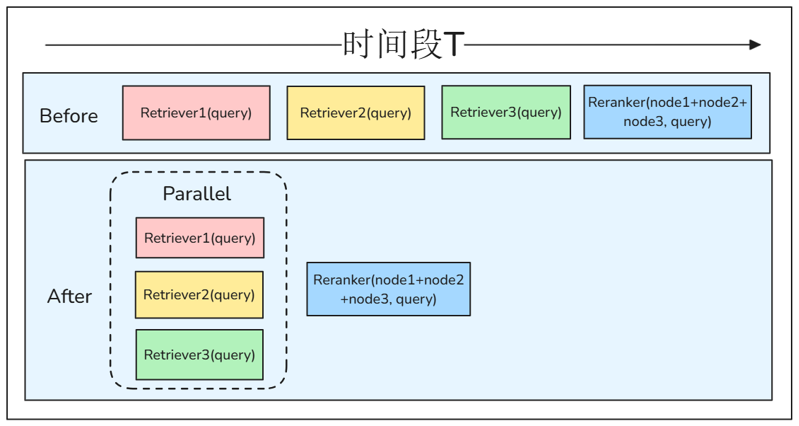

代码如下：

In [ ]:
milvus_store_conf = {
    'type': 'milvus',
    'kwargs': {
        'uri': "dbs/test_parallel.db",
        'index_kwargs': {
        'index_type': 'HNSW',
        'metric_type': 'COSINE',
        }
    }
}
dataset_path = os.path.join(DOC_PATH, "test")

docs1 = lazyllm.Document(
    dataset_path=dataset_path,
    embed=embedding_model,
    store_conf=milvus_store_conf
)
docs1.create_node_group(name='sentence', parent="MediumChunk", transform=(lambda d: d.split('。')))
retriever1 = lazyllm.Retriever(docs1, group_name="MediumChunk", topk=3)
retriever2 = lazyllm.Retriever(docs1, group_name="sentence", target="MediumChunk", topk=3)

retriever1.start()
retriever2.start()

with lazyllm.parallel().sum as prl:
    prl.r1 = retriever1
    prl.r2 = retriever2

query = "证券管理的基本规范？"

st = time.time()
retriever1(query=query)
retriever2(query=query)
et1 = time.time()
prl(query)
et2 = time.time()
print(f"顺序检索耗时：{et1-st}s")
print(f"并行检索耗时：{et2-et1}s")

执行以上代码获得输出：

```bash
顺序检索耗时：0.0436248779296875s
并行检索耗时：0.025980472564697266s
```

可以看出，使用并行检索可以有效节省检索时间，提升检索效率。最后，我们综合以上所有优化策略实现一个优化效率后的高性能RAG系统：

In [ ]:
milvus_store_conf = {
    'type': 'milvus',
    'kwargs': {
        'uri': "dbs/test_rag.db",
        'index_kwargs': {
        'index_type': 'HNSW',
        'metric_type': 'COSINE',
        }
    }
}
dataset_path = os.path.join(DOC_PATH, "test")
# 定义kv缓存
kv_cache = defaultdict(list)

docs1 = lazyllm.Document(dataset_path=dataset_path, embed=embedding_model, store_conf=milvus_store_conf)
docs1.create_node_group(name='sentence', parent="MediumChunk", transform=(lambda d: d.split('。')))

prompt = '你是一个友好的 AI 问答助手，你需要根据给定的上下文和问题提供答案。\
    根据以下资料回答问题：\
    {context_str} \n '

with lazyllm.pipeline() as recall:
    # 并行多路召回
    with lazyllm.parallel().sum as recall.prl:
        recall.prl.r1 = lazyllm.Retriever(docs1, group_name="MediumChunk", topk=6)
        recall.prl.r2 = lazyllm.Retriever(docs1, group_name="sentence", target="MediumChunk", topk=6)
    recall.reranker = lazyllm.Reranker(name='ModuleReranker',model=rerank_model, topk=3) | lazyllm.bind(query=recall.input)
    recall.cache_save = (lambda nodes, query: (kv_cache.update({query: nodes}) or nodes)) | lazyllm.bind(query=recall.input)
    
with lazyllm.pipeline() as ppl:
    # 缓存检查
    ppl.cache_check = lazyllm.ifs(
        cond=(lambda query: query in kv_cache),
        tpath=(lambda query: kv_cache[query]),
        fpath=recall
    )
    ppl.formatter = (
        lambda nodes, query: dict(
            context_str="\n".join(node.get_content() for node in nodes),
            query=query)
    ) | lazyllm.bind(query=ppl.input)
    ppl.llm = llm.prompt(lazyllm.ChatPrompter(instruction=prompt, extro_keys=['context_str']))

w = lazyllm.WebModule(ppl, port=23492, stream=True).start().wait()

[相关视频：video\12_8.mp4](video/12_8.mp4)

# 三、使用 vLLM 框架启动量化模型服务

vLLM 是一个专门为大语言模型（LLM）推理优化的高效推理框架，旨在大幅提升大模型的推理速度，并降低显存占用。它采用了一系列优化技术，如高效的连续批处理（PagedAttention）和动态 KV 缓存管理，使其在 GPU 推理场景下相比传统方法更具优势。

## 1. 直接启动本地服务

LazyLLM 原生支持了 LightLLM、LMDeploy 和 vLLM 三种大模型推理加速框架和 Infinity 嵌入模型加速框架，用户在使用时仅需通过 TrainableModule.deploy_method 指定对应的框架即可。

In [ ]:
from lazyllm import TrainableModule, deploy

llm = TrainableModule('model_name').deploy_method(deploy.vllm)

vLLM 支持多数大模型的推理服务，您可以先确认您想用的模型是否在 [LazyLLM支持的模型列表](https://docs.lazyllm.ai/zh-cn/stable/Home/model_list/)中。在这个列表中后面带有 AWQ、4bit 等标识的都是量化模型，您可以根据您的需求选择一个量化模型然后启动对话服务，例如

In [ ]:
from lazyllm import TrainableModule, deploy

llm = TrainableModule('Qwen2-72B-Instruct-AWQ').deploy_method(deploy.vllm).start()
print(llm("hello, who are you?"))

我们以 Qwen2-72B-Instruct 和它的 AWQ 量化版本为例，对比一下二者的大小及运行速度。运行BF16或FP16 的 Qwen2-72B-Instruct 模型运行需要至少144GB显存（例如2xA100-80G或5xV100-32G）；运行 Int4 模型至少需要 48GB 显存（例如1xA100-80G或2xV100-32G），是原来的33%（数据来源于 Qwen 官方[[魔塔社区](https://modelscope.cn/models/qwen/Qwen-72B/)]）。

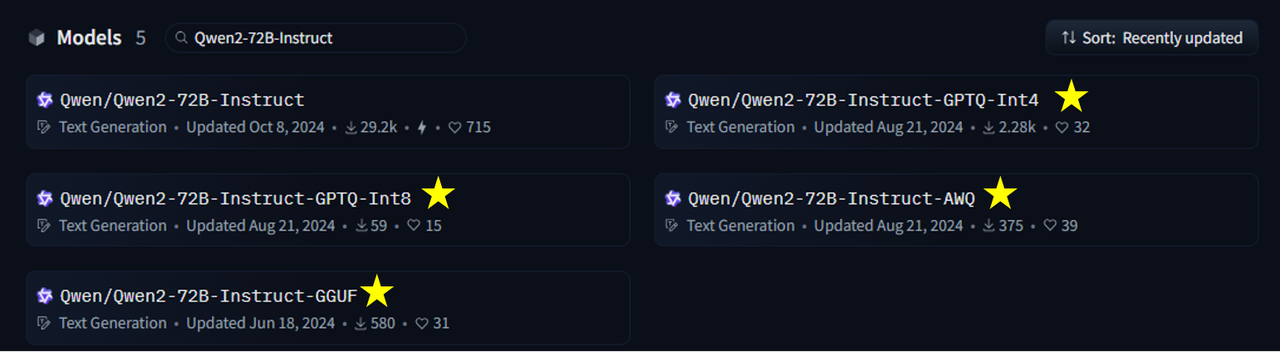

下面我们简单对比一下二者的运行速度（更严谨的情况下可以对比多次执行的差异，完整代码见[GitHub链接](https://github.com/LazyAGI/Tutorial/blob/patch-4/rag/codes/chapter12/use_quantized_llm.py)）：

In [ ]:
import time
from lazyllm import TrainableModule, deploy, launchers

start_time = time.time()
llm = TrainableModule('Qwen2-72B-Instruct').deploy_method(
        deploy.Vllm).start()

end_time = time.time()
print("原始模型加载耗时：", end_time-start_time)

start_time = time.time()
llm_awq = TrainableModule('Qwen2-72B-Instruct-AWQ').deploy_method(deploy.Vllm).start()
end_time = time.time()
print("AWQ量化模型加载耗时：", end_time-start_time)

query = "生成一份1000字的人工智能发展相关报告"

start_time = time.time()
llm(query)
end_time = time.time()
print("原始模型耗时：", end_time-start_time)

start_time = time.time()
llm_awq(query)
end_time = time.time()
print("AWQ量化模型耗时：", end_time-start_time)

同样在 4 张 A800 卡加载和执行的速度如下所示：

> 原始模型加载耗时： 129.6051540374756
>
> 原始模型耗时： 13.104065895080566
>
> AWQ量化模型加载耗时： 86.4980857372284
>
> AWQ量化模型耗时： 8.81701111793518

LazyLLM 输出的日志信息中的 token/s 信息分别为：

> INFO 03-12 19:52:50 metrics.py:341] Avg prompt throughput: 6.6 tokens/s, Avg generation throughput: 30.8 tokens/s
>
> INFO 03-12 20:00:03 metrics.py:341] Avg prompt throughput: 6.6 tokens/s, Avg generation throughput: 41.2 tokens/s

AWQ 模型在单卡上的加载和执行耗时为：137 秒和 23 秒，也就是说，当有 4 张卡的时候，量化模型可以多处理 1.3-1.4 倍的请求。而当用户无法满足执行原模型的资源时，可以通过量化模型获得与原模型效果差异不大的生成效果（[官方数据](https://qwen.readthedocs.io/en/latest/benchmark/quantization_benchmark.html)称量化模型在MMLU，CEval，IEval上的评测平均值只差0.9个点）。

## 2. 通过 OnlineChatModule 访问 vLLM API

vLLM 发布的 API 接口和 OpenAI 是一致的，因此我们可以通过 lazyllm.OnlineChatModule 实现接口访问。这种方式的优势是大模型服务与 RAG 系统解耦，重启系统时无需重新启动模型服务，节省模型加载的耗时。

对于Qwen2-72B-Instruct模型，直接使用 vLLM 的启动方式为在命令行输入：

```bash
vllm serve /path/to/your/model \
        --quantization awg_marlin \
        --served-model-name qwen2 \
        --host 0.0.0.0 \
        --port 25120 \ 
        --trust-remote-code

如果您的 vLLM 版本低于 0.5.3，则同过如下命令：

```bash
python -m vllm.entrypoints.openai.api_server
        --model /path/to/your/model
        --served-model-name qwen2 \
        --host 0.0.0.0 \
        --port 25120

然后我们在 LazyLLM 中访问：

In [ ]:
from lazyllm import OnlineChatModule

# 需要抛出环境变量 LAZYLLM_OPENAI_API_KEY 指定服务接口为 openai 模式
# export LAZYLLM_OPENAI_API_KEY=sk...
llm = OnlineChatModule(model="qwen2", base_url="http://127.0.0.1:25120/v1/")
print(llm('hello'))

输出

> Hello! How can I assist you today?

这种方式可以有效减少调试过程中频繁重启系统带来的时间消耗，在正式系统重启时也可以和持久化存储一起减少系统的启动时间。如果您想使用自己的 token 进行验证，可以在启动vLLM 服务时通过传入 `--api-key <your-api-key>` ，然后在访问时通过设置环境变量 `LAZYLLM_OPENAI_API_KEY` 完成校验。

此外，如果您自定有了服务接口，您也可以通过继承实现 OnlineChatModuleBase 实现自己的在线对话接口：

In [ ]:
import lazyllm
from lazyllm.module import OnlineChatModuleBase
from lazyllm.module.onlineChatModule.fileHandler import FileHandlerBase
class CustomChatModule(OnlineChatModuleBase):
    def __init__(self,
        base_url: str = "<new platform base url>",
        model: str = "<new platform model name>",
        system_prompt: str = "<new platform system prompt>",
        stream: bool = True,
        return_trace: bool = False):
        super().__init__(model_type="new_class_name",
            api_key=lazyllm.config['new_platform_api_key'],
            base_url=base_url,
            system_prompt=system_prompt,
            stream=stream,
            return_trace=return_trace)

## 基于向量数据库和 vLLM 服务的 RAG 系统

将本篇教程中的所有策略（基于向量数据库的持久化存储和高速向量搜索，vLLM启动量化推理模型）应用至进阶1 介绍的多路召回 RAG ，则得到如下代码，在同等条件下，相比于前面的版本启动时间显著减少，响应时间有一定的缩短。

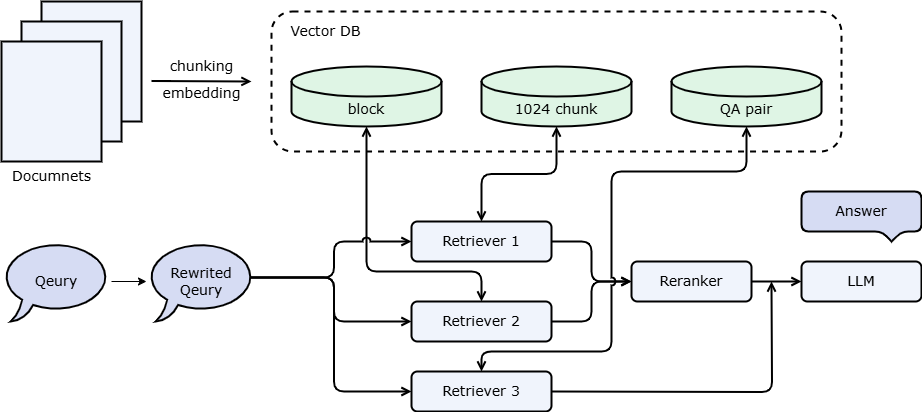

我们在进阶1中提到了使用QA对的用法并推荐在学习向量数据库后进行调试，这是因为QA对提取需要耗费较长的时间和较多的token，如果每次重启系统都执行一次则会浪费大量时间和token，但如果使用了持久化存储策略，则可以每次重启系统时的等待时间，结合文档管理接口，您还可以对大模型提取的QA对进行调整和删除。

In [ ]:
import lazyllm
from lazyllm import bind

# 使用 Milvus 存储后端
chroma_store_conf = {
  'type': 'chroma', 
  'kwargs': {
    'dir': 'qa_pair_chromadb',
   },
  'indices': {
    'smart_embedding_index': {
      'backend': 'milvus',
      'kwargs': {
        'uri': "qa_pair/test.db",
        'index_kwargs': {
          'index_type': 'HNSW',
          'metric_type': 'COSINE',
        }
      },
    },
  },
}

rewriter_prompt = "你是一个查询重写助手，负责给用户查询进行模板切换。\
          注意，你不需要进行回答，只需要对问题进行重写，使更容易进行检索\
          下面是一个简单的例子：\
          输入：RAG是啥？\
          输出：RAG的定义是什么？"
rag_prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task.'\
    ' In this task, you need to provide your answer based on the given context and question.'

# 定义嵌入模型和重排序模型
# online_embedding = lazyllm.OnlineEmbeddingModule()
embedding_model = lazyllm.TrainableModule("bge-large-zh-v1.5").start()

# 如果您要使用在线重排模型
# 目前LazyLLM仅支持 qwen和glm 在线重排模型，请指定相应的 API key。
# online_rerank = lazyllm.OnlineEmbeddingModule(type="rerank")
# 本地重排序模型
offline_rerank = lazyllm.TrainableModule('bge-reranker-large').start()

llm = lazyllm.OnlineChatModule(base_url="http://127.0.0.1:36858/v1")

qa_parser = lazyllm.LLMParser(llm, language="zh", task_type="qa")

docs = lazyllm.Document("/path/to/your/document", embed=embedding_model, store_conf=chroma_store_conf)
docs.create_node_group(name='block', transform=(lambda d: d.split('\n')))
docs.create_node_group(name='qapair', transform=qa_parser)

def retrieve_and_rerank():
    with lazyllm.pipeline() as ppl:
        with lazyllm.parallel().sum as ppl.prl:
            # CoarseChunk是LazyLLM默认提供的大小为1024的分块名
            ppl.prl.retriever1 = lazyllm.Retriever(doc=docs, group_name="CoarseChunk", index="smart_embedding_index", topk=3)
            ppl.prl.retriever2 = lazyllm.Retriever(doc=docs, group_name="block", similarity="bm25_chinese", topk=3)
        ppl.reranker = lazyllm.Reranker("ModuleReranker",
                                         model=offline_rerank,
                                         topk=3) | bind(query=ppl.input)
    return ppl

with lazyllm.pipeline() as ppl:
    # llm.share 表示复用一个大模型，如果这里设置为promptrag_prompt则会覆盖rewrite_prompt
    ppl.query_rewriter = llm.share(lazyllm.ChatPrompter(instruction=rewriter_prompt))
    with lazyllm.parallel().sum as ppl.prl:
        ppl.prl.retrieve_rerank = retrieve_and_rerank()
        ppl.prl.qa_retrieve = lazyllm.Retriever(doc=docs, group_name="qapair", index="smart_embedding_index", topk=3)      
    ppl.formatter = (
          lambda nodes, query: dict(
              context_str='\n'.join([node.get_content() for node in nodes]),
              query=query)
        ) | bind(query=ppl.input)
    ppl.llm = llm.share(lazyllm.ChatPrompter(instruction=rag_prompt, extra_keys=['context_str']))

lazyllm.WebModule(ppl, port=23491, stream=True).start().wait()

[相关视频：video\12_9.mp4](video/12_9.mp4)


基于本节教程内容关于 LazyLLM 如何使用向量数据库实现持久化存储和高速向量检索的相关内容，可以有效减少RAG系统在重启和执行阶段的计算耗时，在某些特定节点组的角度还可以节省大量 token 费用。其次，通过灵活使用 vLLM 框架，可以得到更快的推理速度，通过使用量化模型，可以在保留相似的生成效果的条件下，压低硬件要求，节省硬件成本，也可以减少模型启动时的模型加载时间。